# imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
from statistics import median, mean
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from scipy.spatial import ConvexHull


# definitions

In [2]:
lock_box_parts = {
    "middle_front": (0, 0, 0),
    "lever_tip": (49, 24, 15),
    "upper_lever_tip": (49, 87, 82),
    "stick_head": (-9, 35, 9),
    "ball": (86, 34, 15),
    "sliding_door": (86, 67, 10),
    "middle_back": (0, 140, 0),
    "left_front": (120, 0, 0)
}
# E1
hdf5_path_front = '/home/box/coding/CTIR/videos/experiment_1/E1_frontDLC_resnet101_Moused_4Jul10shuffle1_10000.h5'
hdf5_path_side = '/home/box/coding/CTIR/videos/experiment_1/E1_sideDLC_resnet101_Moused_4Jul10shuffle1_10000.h5'
hdf5_path_top = '/home/box/coding/CTIR/videos/experiment_1/E1_topDLC_resnet101_Moused_4Jul10shuffle1_10000.h5'

data = {
    'file': ['E1_front.png', 'E1_side.png', 'E1_top.png'],
    'lever_tip_x': [525.36, 808.65, 352.30],
    'lever_tip_y': [446.67, 373.74, 162.13],
    'upper_lever_tip_x': [506.80, 513.50, 348.21],
    'upper_lever_tip_y': [109.76, 66.99, 302.43],
    'stick_head_x': [261.87, 734.33, 501.62],
    'stick_head_y': [474.28, 463.10, 201.38],
    'ball_x': [688.95, 759.18, 253.07],
    'ball_y': [439.52, 350.62, 194.87],
    'sliding_door_x': [675.83, 638.41, 254.25],
    'sliding_door_y': [402.94, 350.62, 274.80],
    'middle_front_x': [308.33, 891.28, 471.89],
    'middle_front_y': [547.63, 486.68, 122.95],
    'middle_back_x': [317.01, 256.59, 471.34],
    'middle_back_y': [402.21, 482.78, 469.96],
    'left_front_x': [844.89, 891.41, 182.05],
    'left_front_y': [522.60, 380.02, 118.33]
}

# E2
# hdf5_path_front = 'video_data/E2/E2_frontDLC_resnet101_Moused_4Jul10shuffle1_10000.h5'
# hdf5_path_side = 'video_data/E2/E2_sideDLC_resnet101_Moused_4Jul10shuffle1_10000.h5'
# hdf5_path_top = 'video_data/E2/E2_topDLC_resnet101_Moused_4Jul10shuffle1_10000.h5'

# data = {    #reference points
#     'file': ['E2_front.png', 'E2_side.png', 'E2_top.png'],
#     'lever_tip_x': [594.07, 790.17, 342.84],
#     'lever_tip_y': [446.16, 375.81, 185.17],
#     'upper_lever_tip_x': [583.69, 491.29, 326.91],
#     'upper_lever_tip_y': [119.46, 94.23, 334.09],
#     'stick_head_x': [329.51, 730.67, 493.99],
#     'stick_head_y': [463.98, 454.72, 217.51],
#     'ball_x': [743.19, 743.29, 249.76],
#     'ball_y': [446.19, 360.61, 216.82],
#     'sliding_door_x': [727.62, 641.30, 252.88],
#     'sliding_door_y': [416.66, 365.87, 285.31],
#     'middle_front_x': [366.38, 879.53, 471.87],
#     'middle_front_y': [536.87, 480.34, 144.01],
#     'middle_back_x': [356.72, 246.75, 472.18],
#     'middle_back_y': [401.98, 492.33, 487.91],
#     'left_front_x': [889.03, 868.64, 182.44],
#     'left_front_y': [531.88, 394.87, 140.09]
# }


# functions

In [3]:
def triangulate_points(points_2d_front, points_2d_side, points_2d_top, P_front, P_side, P_top):
    points_3d = []
    for i in range(points_2d_front.shape[0]):
        A = []
        x, y = points_2d_front[i]
        A.append(x * P_front[2, :] - P_front[0, :])
        A.append(y * P_front[2, :] - P_front[1, :])
        
        x, y = points_2d_side[i]
        A.append(x * P_side[2, :] - P_side[0, :])
        A.append(y * P_side[2, :] - P_side[1, :])
        
        x, y = points_2d_top[i]
        A.append(x * P_top[2, :] - P_top[0, :])
        A.append(y * P_top[2, :] - P_top[1, :])
        
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        points_3d.append(X[:3] / X[3])
    return np.array(points_3d)
def weighted_triangulate_points(points_2d_front, points_2d_side, points_2d_top, P_front, P_side, P_top, likelihoods):
    points_3d = []
    for i in range(points_2d_front.shape[0]):
        A = []
        
        x, y = points_2d_front[i]
        A.append(likelihoods['front'][i] * (x * P_front[2, :] - P_front[0, :]))
        A.append(likelihoods['front'][i] * (y * P_front[2, :] - P_front[1, :]))
        
        x, y = points_2d_side[i]
        A.append(likelihoods['side'][i] * (x * P_side[2, :] - P_side[0, :]))
        A.append(likelihoods['side'][i] * (y * P_side[2, :] - P_side[1, :]))
        
        x, y = points_2d_top[i]
        A.append(likelihoods['top'][i] * (x * P_top[2, :] - P_top[0, :]))
        A.append(likelihoods['top'][i] * (y * P_top[2, :] - P_top[1, :]))
        
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        points_3d.append(X[:3] / X[3])
    
    return np.array(points_3d)
def distance_3d(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2 + (coord1[2] - coord2[2])**2)
def calculate_distance(df):
    d = []
    for i in range(len(df) - 1):
        dist = distance_3d(
            [df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['z']],
            [df.iloc[i+1]['x'], df.iloc[i+1]['y'], df.iloc[i+1]['z']]
        )
        d.append(dist)
    d.append(0)
    df['dist'] = d
def triangle_area_3d(A, B, C):
    # Convert points to numpy arrays
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    
    # Compute the vectors AB and AC
    AB = B - A
    AC = C - A
    
    # Compute the cross product of AB and AC
    cross_product = np.cross(AB, AC)
    
    # Compute the magnitude of the cross product
    area = np.linalg.norm(cross_product) / 2.0
    
    return area
def triangle_centroid_3d(A, B, C):
    # Convert points to numpy arrays
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    
    # Compute the centroid
    centroid = (A + B + C) / 3.0
    
    return centroid
def calculate_camera_params(points_3d, points_2d):
    num_points = points_3d.shape[0]
    A = []
    for i in range(num_points):
        X, Y, Z = points_3d[i]
        u, v = points_2d[i]
        A.append([-X, -Y, -Z, -1, 0, 0, 0, 0, u*X, u*Y, u*Z, u])
        A.append([0, 0, 0, 0, -X, -Y, -Z, -1, v*X, v*Y, v*Z, v])
    A = np.array(A)
    
    # Perform SVD
    U, S, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)
    
    # Decompose P to obtain K, R, t
    K, R, t = cv2.decomposeProjectionMatrix(P)[:3]
    K /= K[2, 2]  # Normalize K to make K[2, 2] = 1
    
    # Correct the sign and orientation if needed
    if np.linalg.det(R) < 0:
        R = -R
        t = -t
    
    return K, R, t, P
def calculate_reprojection_error(P, points_3d, points_2d):
    num_points = points_3d.shape[0]
    points_2d_reproj = P @ np.hstack((points_3d, np.ones((num_points, 1)))).T
    points_2d_reproj /= points_2d_reproj[2]  # Divide by the last row to normalize
    points_2d_reproj = points_2d_reproj[:2].T
    reprojection_error = np.mean(np.linalg.norm(points_2d - points_2d_reproj, axis=1))
    return reprojection_error
def extract_xyz(df, index):
    if index not in df.index:
        raise ValueError("Index not found in DataFrame.")
    return df.loc[index, ['x', 'y', 'z']].values

# projection matrix

In [4]:
# Convert dictionary to numpy array
points_3d = np.array(list(lock_box_parts.values()), dtype='float32')

df = pd.DataFrame(data)

# Extract 2D points
points_2d_front = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[0].values
points_2d_front = np.vstack((points_2d_front, df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[0].values)).T

points_2d_side = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[1].values
points_2d_side = np.vstack((points_2d_side, df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[1].values)).T

points_2d_top = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[2].values
points_2d_top = np.vstack((points_2d_top, df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[2].values)).T


# Calculate camera parameters and reprojection errors for each view
K_front, R_front, t_front, P_front = calculate_camera_params(points_3d, points_2d_front)
reprojection_error_front = calculate_reprojection_error(P_front, points_3d, points_2d_front)

K_side, R_side, t_side, P_side = calculate_camera_params(points_3d, points_2d_side)
reprojection_error_side = calculate_reprojection_error(P_side, points_3d, points_2d_side)

K_top, R_top, t_top, P_top = calculate_camera_params(points_3d, points_2d_top)
reprojection_error_top = calculate_reprojection_error(P_top, points_3d, points_2d_top)

# lockbox elements

In [5]:
def process_data(hdf5_path_front, hdf5_path_side, hdf5_path_top):
    # Load the data
    box_f = pd.read_hdf(hdf5_path_front)
    box_s = pd.read_hdf(hdf5_path_side)
    box_t = pd.read_hdf(hdf5_path_top)

    columns_to_keep = ['lever_tip', 'upper_lever_tip', 'stick_head', 'ball', 'sliding_door', 'plateau_middle_back', 'plateau_middle_front', 'sliding_door_top_left', 'sliding_door_top_right', 'sliding_door_bottom_left', 'sliding_door_bottom_right']

    # Filter columns
    def filter_columns(df):
        df = df.loc[:, df.columns.get_level_values(1).isin(columns_to_keep)]
        df.columns = df.columns.droplevel(0)
        df.columns = df.columns.map('_'.join).str.strip('|')
        return df

    box_f = filter_columns(box_f)
    box_s = filter_columns(box_s)
    box_t = filter_columns(box_t)

    return box_f, box_s, box_t
def get_data(point_name, box_f, box_s, box_t, P_front, P_side, P_top, weighted_triangulate_points, calculate_distance):
    # Stack the data
    def stack_data(df, column):
        return np.column_stack((df[f'{column}_x'], df[f'{column}_y']))

    point_f = stack_data(box_f, point_name)
    point_s = stack_data(box_s, point_name)
    point_t = stack_data(box_t, point_name)

    # Likelihoods
    def create_likelihood_df(box_f, box_s, box_t, column):
        return pd.DataFrame({'front': box_f[f'{column}_likelihood'], 'side': box_s[f'{column}_likelihood'], 'top': box_t[f'{column}_likelihood']})

    likelihoods = create_likelihood_df(box_f, box_s, box_t, point_name)

    # Triangulate points
    points_3d = weighted_triangulate_points(point_f, point_s, point_t, P_front, P_side, P_top, likelihoods)
    points_3d_df = pd.DataFrame(points_3d, columns=['x', 'y', 'z'])

    # Calculate distances
    calculate_distance(points_3d_df)

    return points_3d_df, likelihoods

box_f, box_s, box_t = process_data(hdf5_path_front, hdf5_path_side, hdf5_path_top)

lever_tip_3d, lever_tip_lks = get_data('lever_tip', box_f, box_s, box_t, P_front, P_side, P_top, weighted_triangulate_points, calculate_distance)
upper_lever_tip_3d, upper_lever_tip_lks = get_data('upper_lever_tip', box_f, box_s, box_t, P_front, P_side, P_top, weighted_triangulate_points, calculate_distance)
stick_head_3d, stick_head_lks = get_data('stick_head', box_f, box_s, box_t, P_front, P_side, P_top, weighted_triangulate_points, calculate_distance)
ball_3d, ball_lks = get_data('ball', box_f, box_s, box_t, P_front, P_side, P_top, weighted_triangulate_points, calculate_distance)
middle_back_3d, middle_back_lks = get_data('plateau_middle_back', box_f, box_s, box_t, P_front, P_side, P_top, weighted_triangulate_points, calculate_distance)
middle_front_3d, middle_front_lks = get_data('plateau_middle_front', box_f, box_s, box_t, P_front, P_side, P_top, weighted_triangulate_points, calculate_distance)
sliding_door_3d, sliding_door_lks = get_data('sliding_door', box_f, box_s, box_t, P_front, P_side, P_top, weighted_triangulate_points, calculate_distance)

# body parts likelihood matrix

In [6]:
# Load the data
data_f = pd.read_hdf(hdf5_path_front)
data_s = pd.read_hdf(hdf5_path_side)
data_t = pd.read_hdf(hdf5_path_top)

columns_to_keep = ['nose', 'eye_left', 'eye_right','ear_left', 'ear_right']

data_f = data_f.loc[:, data_f.columns.get_level_values(1).isin(columns_to_keep)]
data_s = data_s.loc[:, data_s.columns.get_level_values(1).isin(columns_to_keep)]
data_t = data_t.loc[:, data_t.columns.get_level_values(1).isin(columns_to_keep)]

data_f.columns = data_f.columns.droplevel(0)
data_s.columns = data_s.columns.droplevel(0)
data_t.columns = data_t.columns.droplevel(0)

data_f.columns = data_f.columns.map('_'.join).str.strip('|')
data_s.columns = data_s.columns.map('_'.join).str.strip('|')
data_t.columns = data_t.columns.map('_'.join).str.strip('|')

# Convert data to 2D arrays
nose_f = np.column_stack((data_f['nose_x'], data_f['nose_y']))
nose_s = np.column_stack((data_s['nose_x'], data_s['nose_y']))
nose_t = np.column_stack((data_t['nose_x'], data_t['nose_y']))

eye_l_f = np.column_stack((data_f['eye_left_x'], data_f['eye_left_y']))
eye_l_s = np.column_stack((data_s['eye_left_x'], data_s['eye_left_y']))
eye_l_t = np.column_stack((data_t['eye_left_x'], data_t['eye_left_y']))
                           
eye_r_f = np.column_stack((data_f['eye_right_x'], data_f['eye_right_y']))
eye_r_s = np.column_stack((data_s['eye_right_x'], data_s['eye_right_y']))
eye_r_t = np.column_stack((data_t['eye_right_x'], data_t['eye_right_y']))

ear_l_f = np.column_stack((data_f['ear_left_x'], data_f['ear_left_y']))
ear_l_s = np.column_stack((data_s['ear_left_x'], data_s['ear_left_y']))
ear_l_t = np.column_stack((data_t['ear_left_x'], data_t['ear_left_y']))

ear_r_f = np.column_stack((data_f['ear_right_x'], data_f['ear_right_y']))
ear_r_s = np.column_stack((data_s['ear_right_x'], data_s['ear_right_y']))
ear_r_t = np.column_stack((data_t['ear_right_x'], data_t['ear_right_y']))

nose_lks = pd.DataFrame({'front':data_f['nose_likelihood'],'side':data_s['nose_likelihood'], 'top':data_t['nose_likelihood']})
eye_l_lks = pd.DataFrame({'front':data_f['eye_left_likelihood'],'side':data_s['eye_left_likelihood'], 'top':data_t['eye_left_likelihood']})
eye_r_lks = pd.DataFrame({'front':data_f['eye_right_likelihood'],'side':data_s['eye_right_likelihood'], 'top':data_t['eye_right_likelihood']})
ear_l_lks = pd.DataFrame({'front':data_f['ear_left_likelihood'],'side':data_s['ear_left_likelihood'], 'top':data_t['ear_left_likelihood']})
ear_r_lks = pd.DataFrame({'front':data_f['ear_right_likelihood'],'side':data_s['ear_right_likelihood'], 'top':data_t['ear_right_likelihood']})

nose_3d = triangulate_points(nose_f, nose_s, nose_t, np.array(P_front), np.array(P_side), np.array(P_top))
eye_l_3d = triangulate_points(eye_l_f, eye_l_s, eye_l_t, np.array(P_front), np.array(P_side), np.array(P_top))
eye_r_3d = triangulate_points(eye_r_f, eye_r_s, eye_r_t, np.array(P_front), np.array(P_side), np.array(P_top))
ear_l_3d = triangulate_points(ear_l_f, ear_l_s, ear_l_t, np.array(P_front), np.array(P_side), np.array(P_top))
ear_r_3d = triangulate_points(ear_r_f, ear_r_s, ear_r_t, np.array(P_front), np.array(P_side), np.array(P_top))

likelihood_show = pd.DataFrame()

likelihood_show['front_nose'] = data_f['nose_likelihood']
likelihood_show['side_nose'] = data_s['nose_likelihood']
likelihood_show['top_nose'] = data_t['nose_likelihood']

likelihood_show['front_eye_l'] = data_f['eye_left_likelihood']
likelihood_show['side_eye_l'] = data_s['eye_left_likelihood']
likelihood_show['top_eye_l'] = data_t['eye_left_likelihood']

likelihood_show['front_eye_r'] = data_f['eye_right_likelihood']
likelihood_show['side_eye_r'] = data_s['eye_right_likelihood']
likelihood_show['top_eye_r'] = data_t['eye_right_likelihood']

likelihood_show['front_ear_l'] = data_f['ear_left_likelihood']
likelihood_show['side_ear_l'] = data_s['ear_left_likelihood']
likelihood_show['top_ear_l'] = data_t['ear_left_likelihood']

likelihood_show['front_ear_r'] = data_f['ear_right_likelihood']
likelihood_show['side_ear_r'] = data_s['ear_right_likelihood']
likelihood_show['top_ear_r'] = data_t['ear_right_likelihood']

likelihood_show[['nose_x', 'nose_y', 'nose_z']] = pd.DataFrame(nose_3d, columns=['x', 'y', 'z'])
likelihood_show[['eye_left_x', 'eye_left_y', 'eye_left_z']] = pd.DataFrame(eye_l_3d, columns=['x', 'y', 'z'])
likelihood_show[['eye_right_x', 'eye_right_y', 'eye_right_z']] = pd.DataFrame(eye_r_3d, columns=['x', 'y', 'z'])
likelihood_show[['ear_left_x', 'ear_left_y', 'ear_left_z']] = pd.DataFrame(ear_l_3d, columns=['x', 'y', 'z'])
likelihood_show[['ear_right_x', 'ear_right_y', 'ear_right_z']] = pd.DataFrame(ear_r_3d, columns=['x', 'y', 'z'])

# lockbox

In [7]:
def get_rot(tip):
    hinge = [49, 87, 15]
    mid_fr = [0, 0, 0]
    mid_b = [0, 140, 0]
    v1 = (hinge[0] - tip[0], hinge[1] - tip[1], hinge[2] - tip[2])
    v2 = (mid_b[0] - mid_fr[0], mid_b[1] - mid_fr[1], mid_b[2] - mid_fr[2])
    
    # Dot product
    dot_product = v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]
    
    # Magnitudes of the vectors
    magnitude_v1 = math.sqrt(v1[0]**2 + v1[1]**2 + v1[2]**2)
    magnitude_v2 = math.sqrt(v2[0]**2 + v2[1]**2 + v2[2]**2)
    
    # Angle in radians
    cos_angle = dot_product / (magnitude_v1 * magnitude_v2)
    
    # Ensure the cosine value is within the valid range to avoid domain errors due to floating point inaccuracies
    cos_angle = max(-1.0, min(1.0, cos_angle))
    angle_radians = math.acos(cos_angle)
    
    # Convert to degrees
    angle_degrees = math.degrees(angle_radians)
    
    # Compute the cross product to determine the rotation direction
    cross_product = (
        v1[1] * v2[2] - v1[2] * v2[1],
        v1[2] * v2[0] - v1[0] * v2[2],
        v1[0] * v2[1] - v1[1] * v2[0]
    )
    
    # Determine if the angle should be more than 180 degrees
    # Here we assume the z-component of the cross product to determine the direction of rotation
    if cross_product[2] < 0:
        angle_degrees = 360 - angle_degrees
    
    return angle_degrees
def get_angle(A_base,A_tip, B_base, B_tip):

    v1 = (A_base[0] - A_tip[0], A_base[1] - A_tip[1], A_base[2] - A_tip[2])
    v2 = (B_base[0] - B_tip[0], B_base[1] - B_tip[1], B_base[2] - B_tip[2])
    
    # Dot product
    dot_product = v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]
    
    # Magnitudes of the vectors
    magnitude_v1 = math.sqrt(v1[0]**2 + v1[1]**2 + v1[2]**2)
    magnitude_v2 = math.sqrt(v2[0]**2 + v2[1]**2 + v2[2]**2)
    
    # Angle in radians
    cos_angle = dot_product / (magnitude_v1 * magnitude_v2)
    
    # Ensure the cosine value is within the valid range to avoid domain errors due to floating point inaccuracies
    cos_angle = max(-1.0, min(1.0, cos_angle))
    angle_radians = math.acos(cos_angle)
    
    # Convert to degrees
    angle_degrees = math.degrees(angle_radians)
    
    # Compute the cross product to determine the rotation direction
    cross_product = (
        v1[1] * v2[2] - v1[2] * v2[1],
        v1[2] * v2[0] - v1[0] * v2[2],
        v1[0] * v2[1] - v1[1] * v2[0]
    )
    return angle_degrees

# Ball
# immobile unless stick_head x < -54, then free
ball_radius = 10
# open if outside 30y and 52x box centered on (86, 34, 15)
# clean up data based on door dynamics
# can only move on y axis up to y = 63 until ball is removed, then up to y = 57 and if stick_head x < -62 can move up to y = 24 (measured from center) 
# open if y <= 57
sliding_door_3d_clean = sliding_door_3d
sliding_door_3d_clean = sliding_door_3d_clean[(sliding_door_3d_clean['x'] > 83)&(sliding_door_3d_clean['x'] < 89)] #should be static at 86
sliding_door_3d_clean = sliding_door_3d_clean[(sliding_door_3d_clean['y'] < 75 )&(sliding_door_3d_clean['y'] > 20)]
sliding_door_3d_clean = sliding_door_3d_clean[(sliding_door_3d_clean['z'] < 15 )&(sliding_door_3d_clean['z'] > 10)] #should be static at 10
# clean up data based on stick dynamics
# immobile unless lever_tip at (49, 87, 82) or stick_head x < -24, then can only move on x axis
# open if stick_head x < -40?
stick_head_3d_clean = stick_head_3d
stick_head_3d_clean = stick_head_3d_clean[(stick_head_3d_clean['x'] > -54)&(stick_head_3d_clean['x'] < 0)]
stick_head_3d_clean = stick_head_3d_clean[(stick_head_3d_clean['y'] < 37 )&(stick_head_3d_clean['y'] > 32)] #should be static at 35
stick_head_3d_clean = stick_head_3d_clean[(stick_head_3d_clean['z'] < 11 )&(stick_head_3d_clean['z'] > 7)] #should be static at 9
# lets's clean up the data based on lever dynamics
# can only move on y and z axis in quarter circle rotating around hinge
# open if lever_tip = (49, 87, 82)
hinge = [49, 87, 15]
lever_tip_3d_clean = lever_tip_3d
lever_tip_3d_clean = lever_tip_3d_clean[(lever_tip_3d_clean['z'] < 90) &(lever_tip_3d_clean['z'] > 0)]  # z can't be higher than 90 or negative
lever_tip_3d_clean = lever_tip_3d_clean[(lever_tip_3d_clean['y'] < 90) &(lever_tip_3d_clean['y'] > 20)]# y can't be higher than 90 or lower than 20
lever_tip_3d_clean = lever_tip_3d_clean[(lever_tip_3d_clean['x'] > 45) &(lever_tip_3d_clean['x'] < 55)]# x can't be more than more than 5 different from 50

a = []
indices = []
for i in range(len(lever_tip_3d)):
    if i in lever_tip_3d_clean.index:
        f1 = extract_xyz(lever_tip_3d_clean,i)
        f3 = extract_xyz(middle_front_3d,i)
        f4 = extract_xyz(middle_back_3d,i)
        
        a.append(get_angle(f4, f3, hinge, f1)) #angle tip to floor
        indices.append(i)
diff_rot = pd.DataFrame({'lower':a}, index=indices)

# kalman filter/smooth bodypart

In [8]:
ftrs = ['nose','eye_left','eye_right','ear_left','ear_right']
ftrs_3d = [ nose_3d, eye_l_3d, eye_r_3d, ear_l_3d, ear_r_3d]

# Extract parts to form the observation matrix H
H_front = np.array(P_front)[:2, :3]
H_side = np.array(P_side)[:2, :3]
H_top = np.array(P_top)[:2, :3]

# Concatenate H matrices vertically to form the final H matrix
H = np.vstack([H_front, H_side, H_top])

# Define constants
dt = 1.0/30  # time step

# Observation matrix (now 6x6)
H_expanded = np.zeros((6, 6))
H_expanded[:2, :3] = H_front[:2, :3]
H_expanded[2:4, :3] = H_side[:2, :3]
H_expanded[4:6, :3] = H_top[:2, :3]

In [9]:
ftr_filtered = {}

for f_ind, f in enumerate(ftrs):
    d_f = data_f[[f + '_x', f + '_y']].to_numpy()
    d_s = data_s[[f + '_x', f + '_y']].to_numpy()
    d_t = data_t[[f + '_x', f + '_y']].to_numpy()
    d_f_c = data_f[f + '_likelihood'].to_numpy()
    d_s_c = data_s[f + '_likelihood'].to_numpy()
    d_t_c = data_t[f + '_likelihood'].to_numpy()
    
    ftr_3d = ftrs_3d[f_ind]

    # Process model for constant velocity with 6 states
    F = np.array([[1, 0, 0, dt, 0, 0],
                [0, 1, 0, 0, dt, 0],
                [0, 0, 1, 0, 0, dt],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1]])

    # Process noise for constant velocity
    Q = np.eye(6) * 0.1

    H_3d = np.zeros((3, 6))
    H_3d[:3, :3] = np.eye(3)

    # Initial state vector [x, y, z, x_dot, y_dot, z_dot]
    x = np.zeros((6, 1))
    x[:3, 0] = ftr_3d.mean(axis=0)  # Initial position

    # Initial covariance matrix
    P = np.eye(6) * 0.1

    x_list = []
    P_list = []

    base_r = 1
    n = 2

    for i in range(len(d_f)):
        # Combine 2D observations into a single vector for the current frame
        z_2d = np.hstack([d_f[i], d_s[i], d_t[i]]).reshape(-1, 1)
        z_3d = ftr_3d[i].reshape(-1, 1)
        
        # Check if the frame has missing detections
        if d_f_c[i] > 0.2 and d_s_c[i] > 0.2 and d_t_c[i] > 0.2:
            # Adjust observation noise matrix based on confidence for the current frame
            confidence_combined = np.array([d_f_c[i], d_f_c[i], d_s_c[i], d_s_c[i], d_t_c[i], d_t_c[i]])
            R_t_2d = np.diag(base_r / confidence_combined**n)
            R_t_3d = np.eye(3) * (nose_lks.iloc[i].sum() / 3)  # Adjust based on confidence in 3D prediction
            
            # Prediction step
            x_pred = F @ x
            P_pred = F @ P @ F.T + Q
            
            # Update step with 2D observations
            S_2d = H_expanded @ P_pred @ H_expanded.T + R_t_2d
            K_2d = P_pred @ H_expanded.T @ np.linalg.inv(S_2d)
            y_2d = z_2d - H_expanded @ x_pred
            x_2d = x_pred + K_2d @ y_2d
            P_2d = (np.eye(6) - K_2d @ H_expanded) @ P_pred
            
            # Update step with 3D observations
            S_3d = H_3d @ P_2d @ H_3d.T + R_t_3d
            K_3d = P_2d @ H_3d.T @ np.linalg.inv(S_3d)
            y_3d = z_3d - H_3d @ x_2d
            x = x_2d + K_3d @ y_3d
            P = (np.eye(6) - K_3d @ H_3d) @ P_2d
        
        x_list.append(x)
        P_list.append(P)

    diff = []
    for i, k in enumerate(x_list):
        diff.append(np.linalg.norm(k[:3] - ftr_3d[i,None].T))
    diff_df = pd.DataFrame(diff, columns=['delta_k'])
    diff_df[['f_p','s_p','t_p']] = nose_lks
    diff_df[['t_x','t_y','t_z']] = pd.DataFrame(ftr_3d, columns=['x', 'y', 'z'])
    tmp = []
    for i in range(len(diff_df)):
        tmp.append([x_list[i][0][0], x_list[i][1][0], x_list[i][2][0]])
    diff_df[['k_x','k_y','k_z']] = pd.DataFrame(tmp, columns=['x', 'y', 'z'])


    # Perform the backward pass (RTS smoother)
    x_smooth_list = [x_list[-1]]
    P_smooth_list = [P_list[-1]]
    for i in range(len(x_list) - 2, -1, -1):
        P_pred = F @ P_list[i] @ F.T + Q
        G = P_list[i] @ F.T @ np.linalg.inv(P_pred)
        x_smooth = x_list[i] + G @ (x_smooth_list[0] - F @ x_list[i])
        P_smooth = P_list[i] + G @ (P_smooth_list[0] - P_pred) @ G.T
        x_smooth_list.insert(0, x_smooth)
        P_smooth_list.insert(0, P_smooth)

    # Calculate differences and plot
    diff = []
    for i, k in enumerate(x_smooth_list):
        diff.append(np.linalg.norm(k[:3] - ftr_3d[i, None].T))

    tmp = []
    for i in range(len(diff_df)):
        tmp.append([x_smooth_list[i][0][0], x_smooth_list[i][1][0], x_smooth_list[i][2][0]])
    diff_df[['s_x', 's_y', 's_z']] = pd.DataFrame(tmp, columns=['x', 'y', 'z'])
    diff_df['delta_s'] = diff
    
    ftr_filtered[f] = diff_df
    
nose_filtered_3d = ftr_filtered['nose']
eye_left_filtered_3d = ftr_filtered['eye_left']
eye_right_filtered_3d = ftr_filtered['eye_right']
ear_left_filtered_3d = ftr_filtered['ear_left']
ear_right_filtered_3d = ftr_filtered['ear_right']

In [10]:
all_indices = diff_rot.index.union(ball_3d.index).union(sliding_door_3d_clean.index).union(stick_head_3d_clean.index).union(box_f.index)

# Reindex each DataFrame without changing row-specific indices
diff_rot = diff_rot.reindex(all_indices)
ball_3d = ball_3d.reindex(all_indices)
sliding_door_3d_clean = sliding_door_3d_clean.reindex(all_indices)
stick_head_3d_clean = stick_head_3d_clean.reindex(all_indices)

nose_filtered_3d_clean = nose_filtered_3d.reindex(all_indices)
eye_left_filtered_3d_clean = eye_left_filtered_3d.reindex(all_indices)
eye_right_filtered_3d_clean = eye_right_filtered_3d.reindex(all_indices)
ear_left_filtered_3d_clean = ear_left_filtered_3d.reindex(all_indices)
ear_right_filtered_3d_clean = ear_right_filtered_3d.reindex(all_indices)

# Fill missing values with the next valid value first (to handle initial NaNs)
diff_rot.fillna(method='bfill', inplace=True)
ball_3d.fillna(method='bfill', inplace=True)
sliding_door_3d_clean.fillna(method='bfill', inplace=True)
stick_head_3d_clean.fillna(method='bfill', inplace=True)

nose_filtered_3d_clean.fillna(method='bfill', inplace=True)
eye_left_filtered_3d_clean.fillna(method='bfill', inplace=True)
eye_right_filtered_3d_clean.fillna(method='bfill', inplace=True)
ear_left_filtered_3d_clean.fillna(method='bfill', inplace=True)
ear_right_filtered_3d_clean.fillna(method='bfill', inplace=True)

# Fill remaining missing values with the previous valid value
diff_rot.fillna(method='ffill', inplace=True)
ball_3d.fillna(method='ffill', inplace=True)
sliding_door_3d_clean.fillna(method='ffill', inplace=True)
stick_head_3d_clean.fillna(method='ffill', inplace=True)

diff_rot['dist'] = abs(diff_rot.iloc[:, 0].diff())
diff_rot['dist'][0] = 0

nose_filtered_3d_clean.fillna(method='ffill', inplace=True)
eye_left_filtered_3d_clean.fillna(method='ffill', inplace=True)
eye_right_filtered_3d_clean.fillna(method='ffill', inplace=True)
ear_left_filtered_3d_clean.fillna(method='ffill', inplace=True)
ear_right_filtered_3d_clean.fillna(method='ffill', inplace=True)

thresh = 2.5
features = {
    'nose': nose_filtered_3d_clean[nose_filtered_3d_clean.filter(like='p').sum(axis=1)>thresh],
    'eye_left': eye_left_filtered_3d_clean[eye_left_filtered_3d_clean.filter(like='p').sum(axis=1)>thresh],
    'eye_right': eye_right_filtered_3d_clean[eye_right_filtered_3d_clean.filter(like='p').sum(axis=1)>thresh],
    'ear_left': ear_left_filtered_3d_clean[ear_left_filtered_3d_clean.filter(like='p').sum(axis=1)>thresh],
    'ear_right': ear_right_filtered_3d_clean[ear_right_filtered_3d_clean.filter(like='p').sum(axis=1)>thresh]
}
# Function to calculate mean Euclidean distance between two sets of 3D coordinates
def mean_distance(df1, df2):
    distances = np.sqrt((df1['s_x'] - df2['s_x'])**2 + (df1['s_y'] - df2['s_y'])**2 + (df1['s_z'] - df2['s_z'])**2)
    return distances.median()
# Calculate mean distances between all features
mean_distances = {}
feature_names = list(features.keys())
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        key = f"{feature_names[i]}_to_{feature_names[j]}"
        mean_distances[key] = mean_distance(features[feature_names[i]], features[feature_names[j]])
mean_distance_matrix = pd.DataFrame(index=feature_names, columns=feature_names)
np.fill_diagonal(mean_distance_matrix.values, 0)
for key, value in mean_distances.items():
    feature1, feature2 = key.split('_to_')
    mean_distance_matrix.loc[feature1, feature2] = value
    mean_distance_matrix.loc[feature2, feature1] = value
mean_distance_matrix = mean_distance_matrix.astype(float)
body_part_range = mean_distance_matrix['nose'].max()
mean_distances = np.array(mean_distance_matrix)
num_points = mean_distances.shape[0]
def objective(X):
    X = X.reshape((3, 3))  # Reshape X to represent nose, eye_left, and ear_left
    nose = X[0]
    eye_left = X[1]
    ear_left = X[2]

    # Reflect across the YZ-plane to get symmetric points
    eye_right = np.array([-eye_left[0], eye_left[1], eye_left[2]])
    ear_right = np.array([-ear_left[0], ear_left[1], ear_left[2]])

    # Reconstruct the full set of points
    points = np.vstack([nose, eye_left, eye_right, ear_left, ear_right])
    
    # Calculate the pairwise distances
    distances = pdist(points)
    distance_matrix = squareform(distances)
    
    # Calculate the objective function (sum of squared differences)
    return np.sum((distance_matrix - mean_distances)**2)
initial_guess = np.random.rand(3 * 3)
result = minimize(objective, initial_guess, method='L-BFGS-B')
nose, eye_left, ear_left = result.x.reshape((3, 3))
eye_right = np.array([-eye_left[0], eye_left[1], eye_left[2]])
ear_right = np.array([-ear_left[0], ear_left[1], ear_left[2]])
optimized_coordinates = np.vstack([nose, eye_left, eye_right, ear_left, ear_right])

nose_filtered_3d_clean['lks'] = nose_filtered_3d_clean.filter(like='p').sum(axis=1)/3
nose_filtered_3d_clean.loc[nose_filtered_3d_clean['lks']<0.2, ['s_x','s_y','s_z']] = 200

eye_left_filtered_3d_clean['lks'] = eye_left_filtered_3d_clean.filter(like='p').sum(axis=1)/3
eye_left_filtered_3d_clean.loc[eye_left_filtered_3d_clean['lks']<0.2, ['s_x','s_y','s_z']] = 200

eye_right_filtered_3d_clean['lks'] = eye_right_filtered_3d_clean.filter(like='p').sum(axis=1)/3
eye_right_filtered_3d_clean.loc[eye_right_filtered_3d_clean['lks']<0.2, ['s_x','s_y','s_z']] = 200

ear_left_filtered_3d_clean['lks'] = ear_left_filtered_3d_clean.filter(like='p').sum(axis=1)/3
ear_left_filtered_3d_clean.loc[ear_left_filtered_3d_clean['lks']<0.2, ['s_x','s_y','s_z']] = 200

ear_right_filtered_3d_clean['lks'] = ear_right_filtered_3d_clean.filter(like='p').sum(axis=1)/3
ear_right_filtered_3d_clean.loc[ear_right_filtered_3d_clean['lks']<0.2, ['s_x','s_y','s_z']] = 200

def smooth_data(df, threshold):
    while len(df[df['dist'] > threshold].index) > 0:
        to_smooth = df[df['dist'] > threshold].index
        for ts in to_smooth:
            lower = ts-1
            higher = ts+1
            lower_check = False
            higher_check = False
            
            if df.loc[lower].dist < threshold:
                lower_check = True
                
            if df.loc[higher].dist < threshold:
                higher_check = True
            
            if lower_check and higher_check:
                df.loc[ts] = (df.loc[lower]+ df.loc[higher])/2
                continue
                
            while not lower_check:
                lower=lower-1
                if df.loc[lower].dist < threshold:
                    lower_check = True
                elif lower == 0:
                    return

            while not higher_check:
                higher=higher+1
                if df.loc[higher].dist < threshold:
                    higher_check = True
                if higher == len(df)-1:
                    return

            if lower_check and higher_check:
                df.loc[ts] = (df.loc[lower]+ df.loc[higher])/2

smooth_data(diff_rot, 20)
smooth_data(ball_3d, 100)
smooth_data(sliding_door_3d_clean, 100)
smooth_data(stick_head_3d_clean, 200)

# annotations

In [11]:
data = np.load('/home/box/coding/CTIR/2021-03-05_08-22-05_manual_annotations.npz')
ethogram_interactions = data['ethogram_interactions']
annotator_data_1 = ethogram_interactions[0]
annotator_data_2 = ethogram_interactions[1]

annotator_lever_df = pd.DataFrame({'l1':annotator_data_1[0, :len(lever_tip_3d)], 'l2':annotator_data_2[0, :len(lever_tip_3d)]})
annotator_stick_df = pd.DataFrame({'l1':annotator_data_1[1, :len(lever_tip_3d)], 'l2':annotator_data_2[1, :len(lever_tip_3d)]})
annotator_ball_df = pd.DataFrame({'l1':annotator_data_1[2, :len(lever_tip_3d)], 'l2':annotator_data_2[2, :len(lever_tip_3d)]})
annotator_door_df = pd.DataFrame({'l1':annotator_data_1[3, :len(lever_tip_3d)], 'l2':annotator_data_2[3, :len(lever_tip_3d)]})

annotator_lever_df['sum'] = (annotator_lever_df['l1'].astype(bool) | annotator_lever_df['l2'].astype(bool)).astype(int)
annotator_stick_df['sum'] = (annotator_stick_df['l1'].astype(bool) | annotator_stick_df['l2'].astype(bool)).astype(int)
annotator_ball_df['sum'] = (annotator_ball_df['l1'].astype(bool) | annotator_ball_df['l2'].astype(bool)).astype(int)
annotator_door_df['sum'] = (annotator_door_df['l1'].astype(bool) | annotator_door_df['l2'].astype(bool)).astype(int)

annotator_lever_df['d_lever'] = (diff_rot['dist'].apply(lambda x: 1 if x > 10 else 0)).astype(int)
annotator_stick_df['d_stick'] = (stick_head_3d_clean['dist'].apply(lambda x: 1 if x > 5 else 0)).astype(int)
annotator_ball_df['d_ball'] = (ball_3d['dist'].apply(lambda x: 1 if x > 5 else 0)).astype(int)
annotator_door_df['d_door'] = (sliding_door_3d_clean['dist'].apply(lambda x: 1 if x > 5 else 0)).astype(int)

In [12]:
def transform_shape(nose_position, centroid_position, shape_coordinates):
    # Compute the current centroid of the shape
   # Compute the current centroid of the shape
    current_centroid = np.mean(shape_coordinates, axis=0)
    
    # Translate shape to origin
    centered_shape = shape_coordinates - current_centroid

    # Determine rotation needed to align the nose
    current_nose_vector = shape_coordinates[0] - current_centroid
    new_nose_vector = nose_position - centroid_position
    rotation_vector = np.cross(current_nose_vector, new_nose_vector)
    rotation_angle = np.arccos(np.dot(current_nose_vector, new_nose_vector) / 
                               (np.linalg.norm(current_nose_vector) * np.linalg.norm(new_nose_vector)))
    
    if np.linalg.norm(rotation_vector) > 1e-8:  # Check for valid rotation vector
        rotation_vector = rotation_vector / np.linalg.norm(rotation_vector)
        rotation = R.from_rotvec(rotation_angle * rotation_vector)
        rotated_shape = rotation.apply(centered_shape)
    else:
        rotated_shape = centered_shape

    # Translate shape to new nose position
    transformed_coordinates = rotated_shape + nose_position - rotated_shape[0]
    
    return transformed_coordinates
def plot_shape(coordinates, labels, ax):
    # Plot points
    for i, label in enumerate(labels):
        ax.scatter(coordinates[i, 0], coordinates[i, 1], coordinates[i, 2], label=label)
    
    # Plot lines
    ax.plot([coordinates[0, 0], coordinates[1, 0]], [coordinates[0, 1], coordinates[1, 1]], [coordinates[0, 2], coordinates[1, 2]], 'k-')
    ax.plot([coordinates[0, 0], coordinates[2, 0]], [coordinates[0, 1], coordinates[2, 1]], [coordinates[0, 2], coordinates[2, 2]], 'k-')
    ax.plot([coordinates[1, 0], coordinates[2, 0]], [coordinates[1, 1], coordinates[2, 1]], [coordinates[1, 2], coordinates[2, 2]], 'k-')
    ax.plot([coordinates[3, 0], coordinates[4, 0]], [coordinates[3, 1], coordinates[4, 1]], [coordinates[3, 2], coordinates[4, 2]], 'k-')
    ax.plot([coordinates[1, 0], coordinates[3, 0]], [coordinates[1, 1], coordinates[3, 1]], [coordinates[1, 2], coordinates[3, 2]], 'k-')
    ax.plot([coordinates[2, 0], coordinates[4, 0]], [coordinates[2, 1], coordinates[4, 1]], [coordinates[2, 2], coordinates[4, 2]], 'k-')
    ax.plot([coordinates[0, 0], coordinates[3, 0]], [coordinates[0, 1], coordinates[3, 1]], [coordinates[0, 2], coordinates[3, 2]], 'k-')
    ax.plot([coordinates[0, 0], coordinates[4, 0]], [coordinates[0, 1], coordinates[4, 1]], [coordinates[0, 2], coordinates[4, 2]], 'k-')
def extract_xyz_special(row, feature):
    return row[[f'{feature}_x', f'{feature}_y', f'{feature}_z']]
def plot_point(ax, point, color='b', label=''):
    ax.scatter(point[0], point[1], point[2], c=color, label=label)
    ax.text(point[0], point[1], point[2], '%s' % (label), size=10, zorder=1, color='k')
def plot_stick(stick_start, fig=None, ax=None):
    if fig is None or ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    cx, cy, cz = stick_start
    segments = [
        (16, 16, 5),   # First 5 units with 16x16
        (4, 4, 55),    # Next 55 units with 4x4
        (16, 16, 5),   # Next 5 units with 16x16
        (4, 4, 55)     # Last 55 units with 4x4
    ]

    current_x = cx

    for (width, height, length) in segments:
        w, h, l = width / 2, height / 2, length
        vertices = [
            [current_x, cy - w, cz - h], [current_x, cy + w, cz - h],
            [current_x, cy + w, cz + h], [current_x, cy - w, cz + h],
            [current_x + l, cy - w, cz - h], [current_x + l, cy + w, cz - h],
            [current_x + l, cy + w, cz + h], [current_x + l, cy - w, cz + h]
        ]
        
        vertices = np.array(vertices)

        edges = [
            (vertices[0], vertices[1]), (vertices[1], vertices[2]), 
            (vertices[2], vertices[3]), (vertices[3], vertices[0]), 
            (vertices[4], vertices[5]), (vertices[5], vertices[6]), 
            (vertices[6], vertices[7]), (vertices[7], vertices[4]), 
            (vertices[0], vertices[4]), (vertices[1], vertices[5]), 
            (vertices[2], vertices[6]), (vertices[3], vertices[7])
        ]

        for edge in edges:
            ax.plot3D(*zip(*edge), color='b')

        ax.scatter3D(*zip(*vertices), color='r')
        current_x += l  # Move to the end of the current segment

    # Set the labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    return fig, ax
def rotate_vertices(vertices, angle_x, angle_y, angle_z):
    angle_x = np.radians(angle_x)
    angle_y = np.radians(angle_y)
    angle_z = np.radians(angle_z)

    # Rotation matrix for x-axis
    rotation_matrix_x = np.array([
        [1, 0, 0],
        [0, np.cos(angle_x), -np.sin(angle_x)],
        [0, np.sin(angle_x), np.cos(angle_x)]
    ])
    
    # Rotation matrix for y-axis
    rotation_matrix_y = np.array([
        [np.cos(angle_y), 0, np.sin(angle_y)],
        [0, 1, 0],
        [-np.sin(angle_y), 0, np.cos(angle_y)]
    ])

    # Rotation matrix for z-axis
    rotation_matrix_z = np.array([
        [np.cos(angle_z), -np.sin(angle_z), 0],
        [np.sin(angle_z), np.cos(angle_z), 0],
        [0, 0, 1]
    ])

    # Combined rotation matrix
    rotation_matrix = np.dot(rotation_matrix_z, np.dot(rotation_matrix_y, np.dot(rotation_matrix_x, np.eye(3))))

    rotated_vertices = [np.dot(rotation_matrix, vertex) for vertex in vertices]
    return rotated_vertices
def plot_multiple_bounding_boxes_lever(bounding_boxes_lever, fig=None, ax=None):
    if fig is None or ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    for bbox in bounding_boxes_lever:
        center, segments, angle_x, angle_y, angle_z = bbox
        cx, cy, cz = center
        current_z = cz

        for (width, length, height) in segments:
            w, l, h = width / 2, length / 2, height / 2
            if width == 20 and length == 16:  # Adjust for the middle segment
                vertices = [
                    [cx - w, cy, current_z], [cx - w, cy + length, current_z],
                    [cx + w, cy + length, current_z], [cx + w, cy, current_z],
                    [cx - w, cy, current_z + height], [cx - w, cy + length, current_z + height],
                    [cx + w, cy + length, current_z + height], [cx + w, cy, current_z + height]
                ]
            else:
                vertices = [
                    [cx - w, cy - l, current_z], [cx - w, cy + l, current_z],
                    [cx + w, cy + l, current_z], [cx + w, cy - l, current_z],
                    [cx - w, cy - l, current_z + height], [cx - w, cy + l, current_z + height],
                    [cx + w, cy + l, current_z + height], [cx + w, cy - l, current_z + height]
                ]
            
            vertices = np.array(vertices)
            rotated_vertices = rotate_vertices(vertices - np.array(center), angle_x, angle_y, angle_z) + np.array(center)

            edges = [
                (rotated_vertices[0], rotated_vertices[1]), (rotated_vertices[1], rotated_vertices[2]), 
                (rotated_vertices[2], rotated_vertices[3]), (rotated_vertices[3], rotated_vertices[0]), 
                (rotated_vertices[4], rotated_vertices[5]), (rotated_vertices[5], rotated_vertices[6]), 
                (rotated_vertices[6], rotated_vertices[7]), (rotated_vertices[7], rotated_vertices[4]), 
                (rotated_vertices[0], rotated_vertices[4]), (rotated_vertices[1], rotated_vertices[5]), 
                (rotated_vertices[2], rotated_vertices[6]), (rotated_vertices[3], rotated_vertices[7])
            ]

            for edge in edges:
                ax.plot3D(*zip(*edge), color='b')

            ax.scatter3D(*zip(*rotated_vertices), color='r')
            current_z += height

    # Set the labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Set the limits
    ax.set_xlim(-100, 150)
    ax.set_ylim(-50, 150)
    ax.set_zlim(-50, 100)

    return fig, ax
def rotate_point(point, angle_x, angle_y, angle_z):
    angle_x = np.radians(angle_x)
    angle_y = np.radians(angle_y)
    angle_z = np.radians(angle_z)

    # Rotation matrix for x-axis
    rotation_matrix_x = np.array([
        [1, 0, 0],
        [0, np.cos(angle_x), -np.sin(angle_x)],
        [0, np.sin(angle_x), np.cos(angle_x)]
    ])
    
    # Rotation matrix for y-axis
    rotation_matrix_y = np.array([
        [np.cos(angle_y), 0, np.sin(angle_y)],
        [0, 1, 0],
        [-np.sin(angle_y), 0, np.cos(angle_y)]
    ])

    # Rotation matrix for z-axis
    rotation_matrix_z = np.array([
        [np.cos(angle_z), -np.sin(angle_z), 0],
        [np.sin(angle_z), np.cos(angle_z), 0],
        [0, 0, 1]
    ])

    # Combined rotation matrix
    rotation_matrix = np.dot(rotation_matrix_z, np.dot(rotation_matrix_y, np.dot(rotation_matrix_x, np.eye(3))))

    rotated_point = np.dot(rotation_matrix, point)
    return rotated_point
def is_point_in_box(point, box_center, box_dimensions, angle_x, angle_y, angle_z):
    px, py, pz = point
    cx, cy, cz = box_center
    w, l, h = box_dimensions

    # Translate point to the box coordinate system
    translated_point = np.array([px - cx, py - cy, pz - cz])

    # Rotate point to align with the box orientation
    rotated_point = rotate_point(translated_point, -angle_x, -angle_y, -angle_z)

    # Check if the point is within the box dimensions
    if (-w / 2 <= rotated_point[0] <= w / 2 and
        -l / 2 <= rotated_point[1] <= l / 2 and
        -h / 2 <= rotated_point[2] <= h / 2):
        return True
    return False
def check_point_intersection(point, bounding_boxes_lever):
    for bbox in bounding_boxes_lever:
        center, segments, angle_x, angle_y, angle_z = bbox
        current_z = center[2]
        for (width, length, height) in segments:
            box_center = (center[0], center[1], current_z + height / 2)
            if is_point_in_box(point, box_center, (width, length, height), angle_x, angle_y, angle_z):
                return True
            current_z += height
    return False
def plot_sliding_door(door_center, fig=None, ax=None):
    if fig is None or ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    cx, cy, cz = door_center
    width = 40
    height = 35
    thickness = 5

    w, h, t = width / 2, height / 2, thickness / 2

    vertices = [
        [cx - w, cy - h, cz - t], [cx - w, cy + h, cz - t],
        [cx + w, cy + h, cz - t], [cx + w, cy - h, cz - t],
        [cx - w, cy - h, cz + t], [cx - w, cy + h, cz + t],
        [cx + w, cy + h, cz + t], [cx + w, cy - h, cz + t]
    ]
    
    vertices = np.array(vertices)

    edges = [
        (vertices[0], vertices[1]), (vertices[1], vertices[2]), 
        (vertices[2], vertices[3]), (vertices[3], vertices[0]), 
        (vertices[4], vertices[5]), (vertices[5], vertices[6]), 
        (vertices[6], vertices[7]), (vertices[7], vertices[4]), 
        (vertices[0], vertices[4]), (vertices[1], vertices[5]), 
        (vertices[2], vertices[6]), (vertices[3], vertices[7])
    ]

    for edge in edges:
        ax.plot3D(*zip(*edge), color='b')

    ax.scatter3D(*zip(*vertices), color='r')
    return fig, ax

In [13]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# def update_graph(loop_ind):
#     ax.clear()
#     # test_index = diff_rot.iloc[loop_ind].name
#     rot = (diff_rot.iloc[loop_ind].lower)
#     ball_center = extract_xyz(ball_3d, loop_ind)
#     door_center = extract_xyz(sliding_door_3d_clean, loop_ind)
#     stick_start = extract_xyz(stick_head_3d_clean, loop_ind)
    
#     nose_x, nose_y, nose_z = extract_xyz_special(nose_filtered_3d_clean.iloc[loop_ind], 's')
#     if nose_y > -20 and nose_y < 280 and nose_x < 120 and nose_x > -200:  
#         points = np.empty((0,3))
#         # points = np.vstack([points, extract_xyz_special(nose_filtered_3d_clean.iloc[loop_ind], 's')])
#         points = np.vstack([points, extract_xyz_special(eye_left_filtered_3d_clean.iloc[loop_ind], 's')])
#         points = np.vstack([points, extract_xyz_special(eye_right_filtered_3d_clean.iloc[loop_ind], 's')])
#         points = np.vstack([points, extract_xyz_special(ear_left_filtered_3d_clean.iloc[loop_ind], 's')])
#         points = np.vstack([points, extract_xyz_special(ear_right_filtered_3d_clean.iloc[loop_ind], 's')])

#         body_centroid = np.mean(points, axis=0)

#         transformed_coordinates = transform_shape([nose_x, nose_y, nose_z], body_centroid, optimized_coordinates)

#         labels = ['nose', 'eye_left', 'eye_right', 'ear_left', 'ear_right']

#         plot_shape(transformed_coordinates, labels, ax)

#         ax.scatter(nose_x,nose_y,nose_z, c='r', label='nose')
    
#     plot_stick(stick_start, fig, ax)
    
#     phi, theta = np.mgrid[0.0:2.0 * np.pi:100j, 0.0:np.pi:50j]
#     x = ball_center[0] + ball_radius * np.sin(theta) * np.cos(phi)
#     y = ball_center[1] + ball_radius * np.sin(theta) * np.sin(phi)
#     z = ball_center[2] + ball_radius * np.cos(theta)
#     ax.plot_surface(x, y, z, color='b', alpha=0.6)
    
#     bounding_boxes_lever = [
#         ([49, 87, 15], [(6, 6, 30), (20, 16, 14), (6, 6, 20)], 270 + rot, 0, 180),
#         ([49, 87, 15], [(6, 6, 30), (20, 16, 14), (6, 6, 20)], 0 - rot, 0, 0)
#     ]
#     plot_multiple_bounding_boxes_lever(bounding_boxes_lever, fig, ax)
#     plot_sliding_door(door_center, fig, ax)

#     for part, coords in lock_box_parts.items():
#         plot_point(ax, coords, label=part)
    
#     ax.set_xlabel('X axis')
#     ax.set_ylabel('Y axis')
#     ax.set_zlabel('Z axis')
#     ax.set_xlim(-100, 150)
#     ax.set_ylim(-50, 150)
#     ax.set_zlim(-50, 150)
    
#     time_sec = loop_ind / 30
#     minutes = int(time_sec // 60)
#     seconds = time_sec % 60
#     ax.text2D(0.05, 0.95, f"Frame index: {loop_ind}, Time: {minutes:02d}:{seconds:05.2f}", transform=ax.transAxes)

# frame_indices = range(0, len(sliding_door_3d), 10)
# ani = animation.FuncAnimation(fig, update_graph, frames=frame_indices, interval=333.3)
# ani.save('3d_animation.gif', writer='imagemagick')
# plt.show()

In [28]:
def check_intersection_with_elements(point, radius, bounding_boxes, ball_center, ball_radius, door_center, door_dimensions, stick_start, stick_segments):
    px, py, pz = point
    interacted = ['nothing','nothing','nothing','nothing']
    
    if py < 0 or py > 280 or px >120 or px < -300:
        return interacted
    
    # Check intersection with bounding boxes (lever)
    for bbox in bounding_boxes:
        center, segments, angle_x, angle_y, angle_z = bbox
        current_z = center[2]
        for (width, length, height) in segments:
            box_center = (center[0], center[1], current_z + height / 2)
            if is_point_in_box(point, box_center, (width + 2*(3*radius), length + 2*(3*radius), height + 2*(3*radius)), angle_x, angle_y, angle_z):
                interacted[0] = 'lever'
                break
            current_z += height

    # Check intersection with ball
    if np.linalg.norm(np.array(point) - np.array(ball_center)) <= ball_radius + radius:
        interacted[1] = 'ball'

    # Check intersection with sliding door
    radius = 4
    door_width, door_height, door_thickness = door_dimensions
    door_w, door_h, door_t = door_width / 2 + radius, door_height / 2 + radius, door_thickness / 2 + radius
    if (door_center[0] - door_w <= px <= door_center[0] + door_w and
        door_center[1] - door_h <= py <= door_center[1] + door_h and
        door_center[2] - door_t <= pz <= door_center[2] + door_t):
        interacted[2] = 'door'

    # Check intersection with stick
    cx, cy, cz = stick_start
    current_x = cx
    radius = 3
    for (width, height, length) in stick_segments:
        w, h, l = width / 2 + radius, height / 2 + radius, length
        if (current_x - radius <= px <= current_x + l + radius and
            cy - w <= py <= cy + w and
            cz - h <= pz <= cz + h):
            interacted[3] = 'stick'
            break
        current_x += l

    return interacted

intersection_check = []
radius = 5  # Define the radius around the point

for loop_ind in range(len(sliding_door_3d)):
    rot = (diff_rot.iloc[loop_ind].lower)
    ball_center = extract_xyz(ball_3d, loop_ind)
    door_center = extract_xyz(sliding_door_3d_clean, loop_ind)
    stick_start = extract_xyz(stick_head_3d_clean, loop_ind)
    
    point = extract_xyz_special(nose_filtered_3d_clean.iloc[loop_ind], 's')
    # STATIC
    ball_radius = 10
    door_dimensions = (40, 35, 5)
    stick_segments = [
        (16, 16, 5),   # First 5 units with 16x16
        (4, 4, 55),    # Next 55 units with 4x4
        (16, 16, 5),   # Next 5 units with 16x16
        (4, 4, 55)     # Last 55 units with 4x4
    ]
    bounding_boxes_lever = [
        ([49, 87, 15], [(6, 6, 30), (20, 16, 14), (6, 6, 20)], 270 + rot, 0, 180),
        ([49, 87, 15], [(6, 6, 30), (20, 16, 14), (6, 6, 20)], 0 - rot, 0, 0)
    ]
    # Example usage of intersection check
    element = check_intersection_with_elements(point, radius, bounding_boxes_lever, ball_center, ball_radius, door_center, door_dimensions, stick_start, stick_segments)
    intersection_check.append(element)

interactions_df = pd.DataFrame(intersection_check, columns=['lever','ball','door','stick'])

# clean data
- lock box can't move when mouse is not in cage


In [29]:
mouse_lks = (nose_filtered_3d_clean['lks'] + eye_left_filtered_3d_clean['lks'] + eye_right_filtered_3d_clean['lks'] + ear_left_filtered_3d_clean['lks'] + ear_right_filtered_3d_clean['lks'])/5

In [30]:
annotator_lever_df.loc[annotator_lever_df.index.isin(mouse_lks[mouse_lks < 0.2].index), 'd_lever'] = 0
annotator_ball_df.loc[annotator_ball_df.index.isin(mouse_lks[mouse_lks < 0.2].index), 'd_ball'] = 0
annotator_door_df.loc[annotator_door_df.index.isin(mouse_lks[mouse_lks < 0.2].index), 'd_door'] = 0
annotator_stick_df.loc[annotator_stick_df.index.isin(mouse_lks[mouse_lks < 0.2].index), 'd_stick'] = 0

# validate

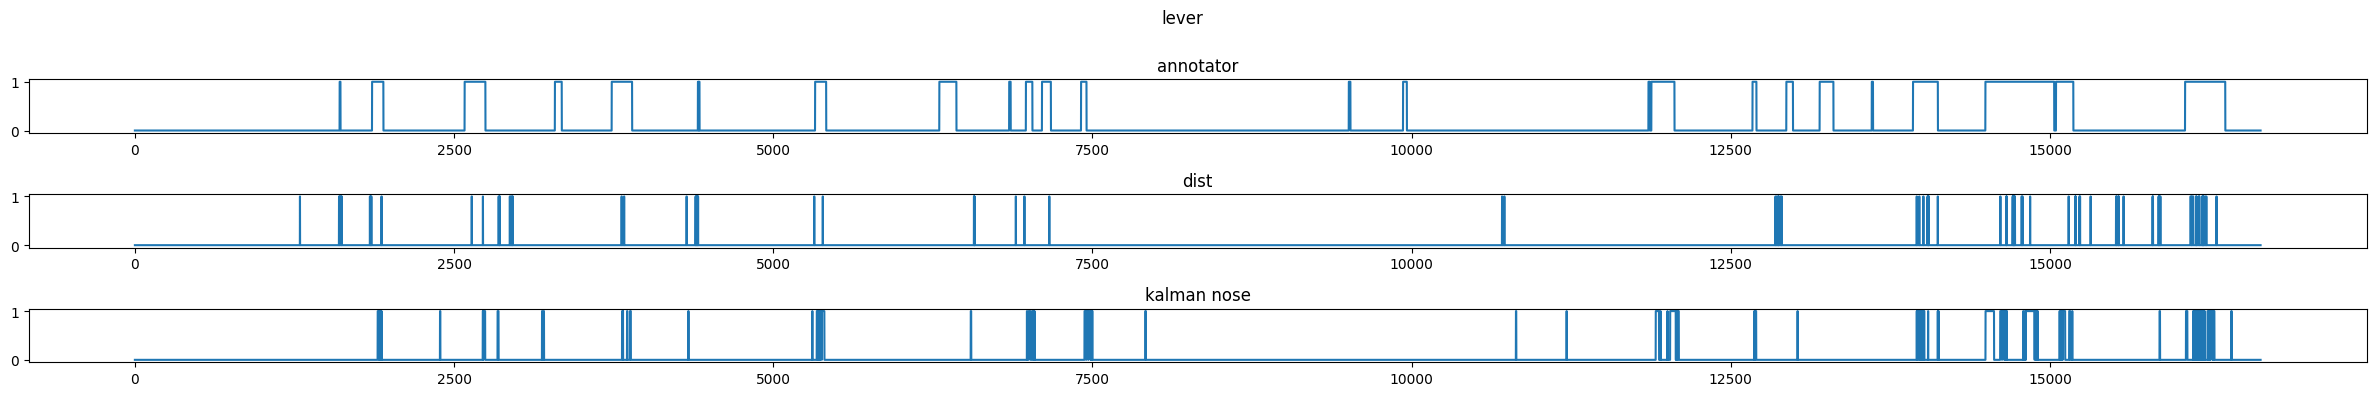

In [31]:
# Assuming annotator_lever_df is already defined and contains 'sum' and 'd' columns.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 4))

ax1.plot(annotator_lever_df['sum'])
ax1.set_title('annotator')

ax2.plot(annotator_lever_df['d_lever'])
ax2.set_title('dist')

ax3.plot(interactions_df['lever'] == 'lever')
ax3.set_title('kalman nose')

fig.suptitle('lever')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

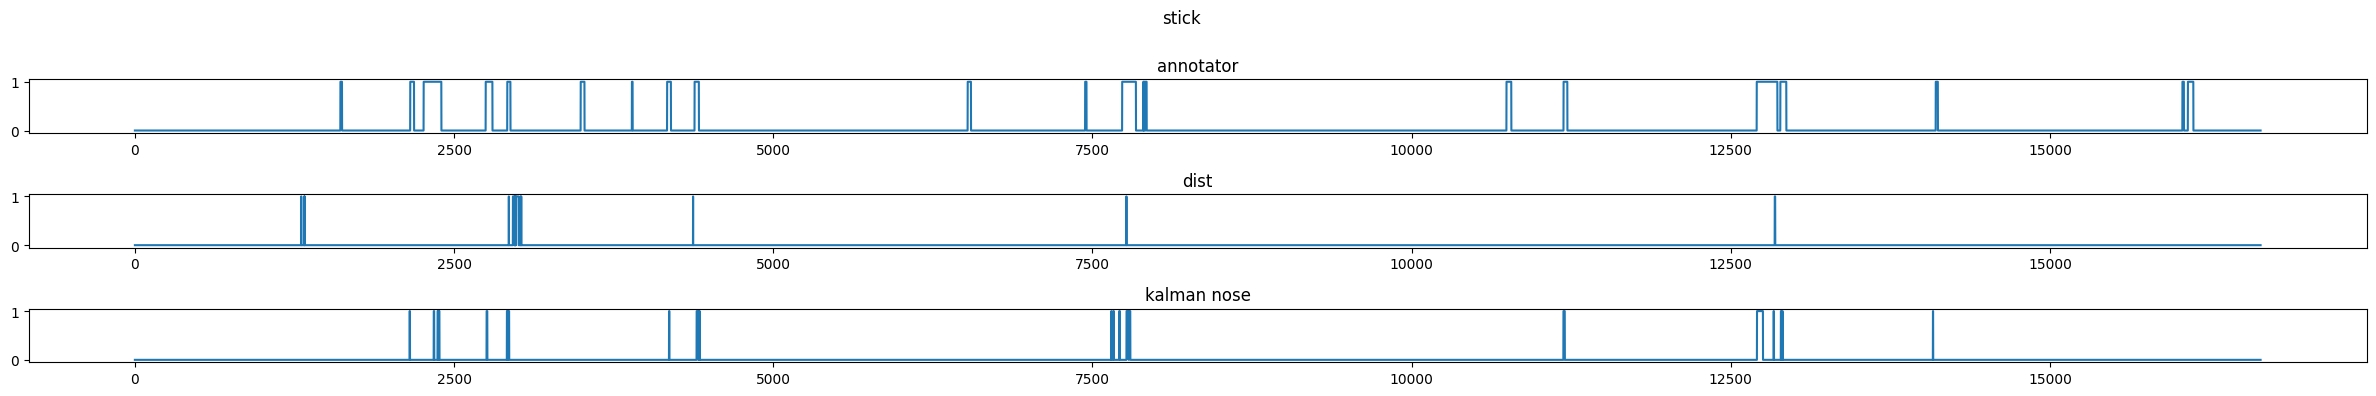

In [32]:
# Assuming annotator_lever_df is already defined and contains 'sum' and 'd' columns.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 4))

ax1.plot(annotator_stick_df['sum'])
ax1.set_title('annotator')

ax2.plot(annotator_stick_df['d_stick'])
ax2.set_title('dist')

ax3.plot(interactions_df['stick'] == 'stick')
ax3.set_title('kalman nose')

fig.suptitle('stick')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

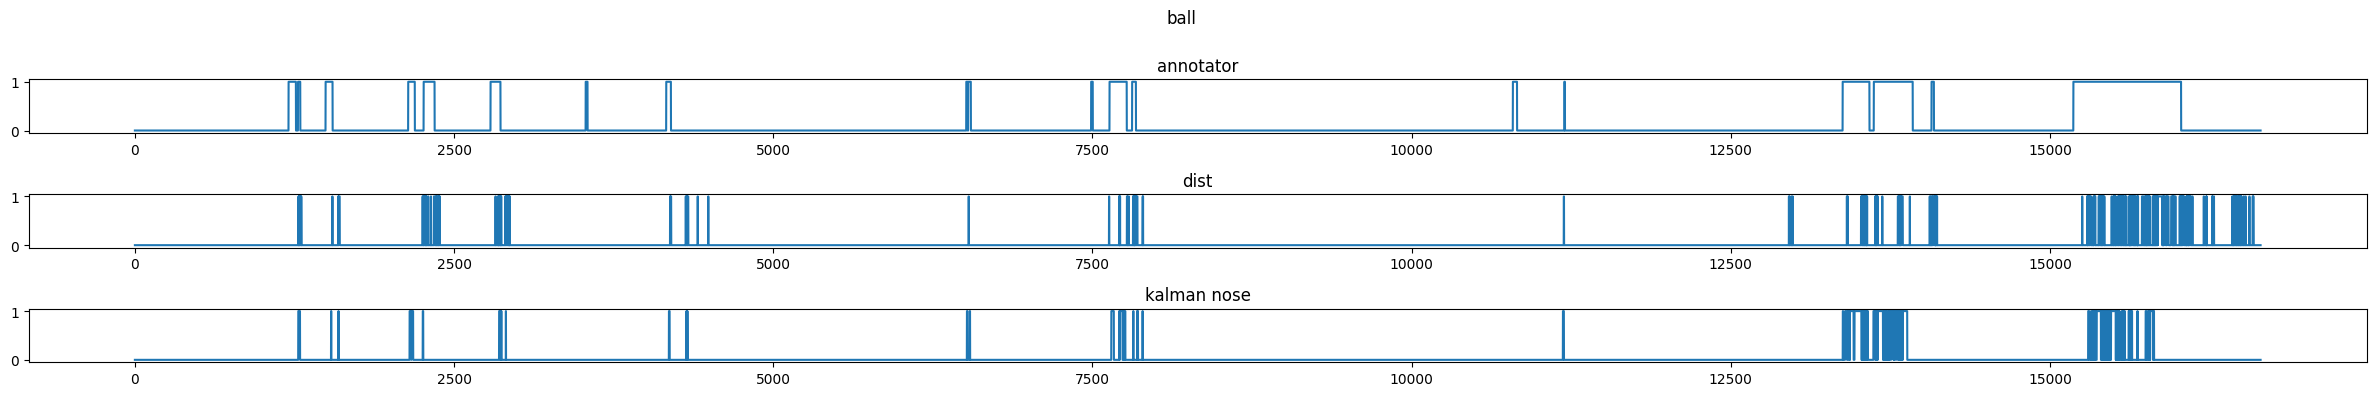

In [33]:
# Assuming annotator_lever_df is already defined and contains 'sum' and 'd' columns.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 4))

ax1.plot(annotator_ball_df['sum'])
ax1.set_title('annotator')

ax2.plot(annotator_ball_df['d_ball'])
ax2.set_title('dist')

ax3.plot(interactions_df['ball'] == 'ball')
ax3.set_title('kalman nose')

fig.suptitle('ball')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

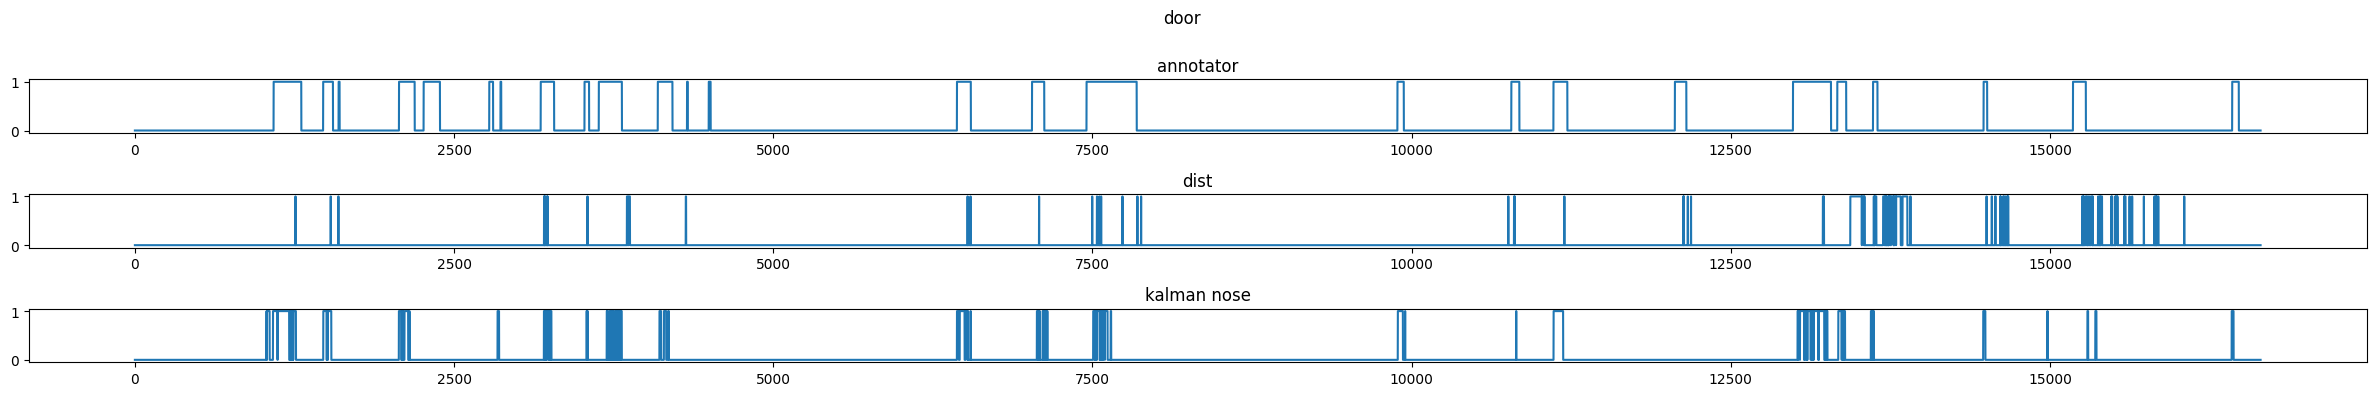

In [34]:
# Assuming annotator_lever_df is already defined and contains 'sum' and 'd' columns.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 4))

ax1.plot(annotator_door_df['sum'])
ax1.set_title('annotator')

ax2.plot(annotator_door_df['d_door'])
ax2.set_title('dist')

ax3.plot(interactions_df['door'] == 'door')
ax3.set_title('kalman nose')

fig.suptitle('door')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()